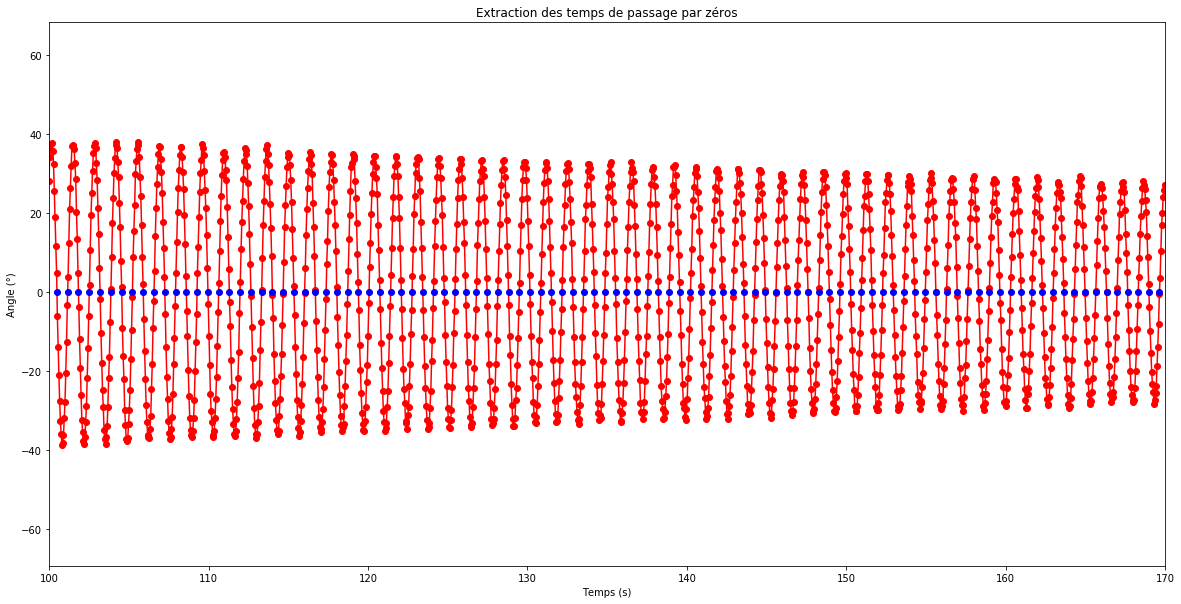

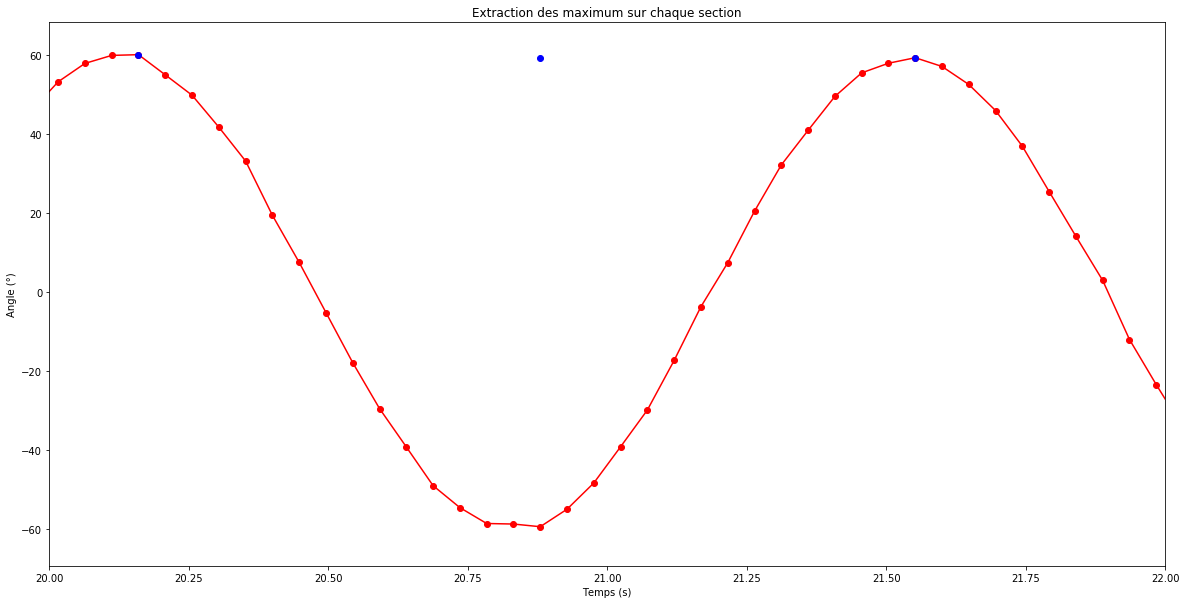

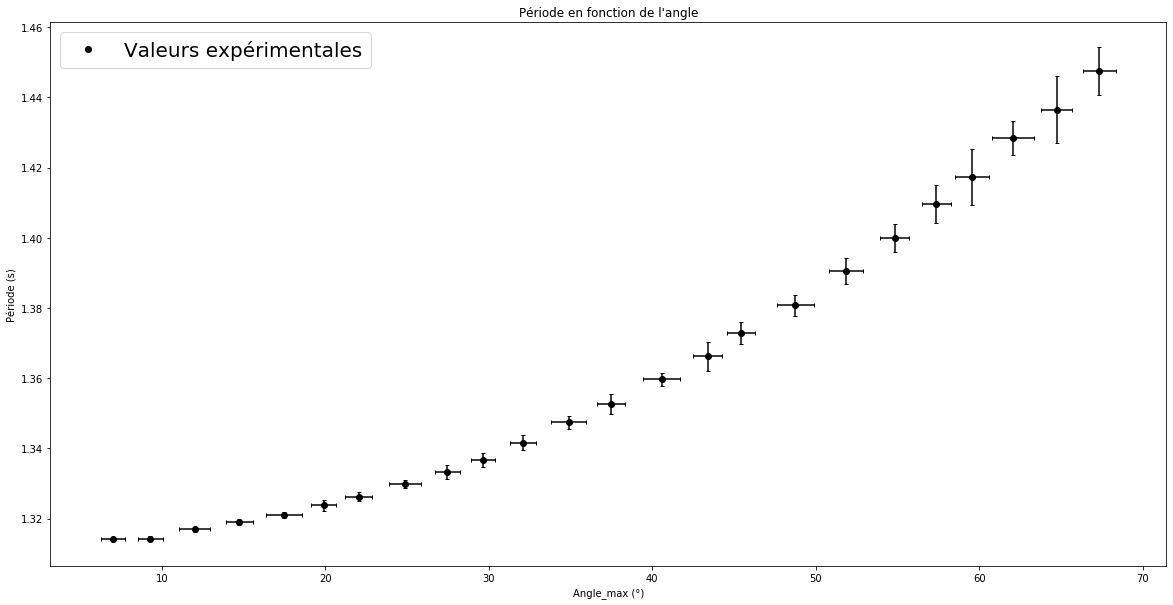

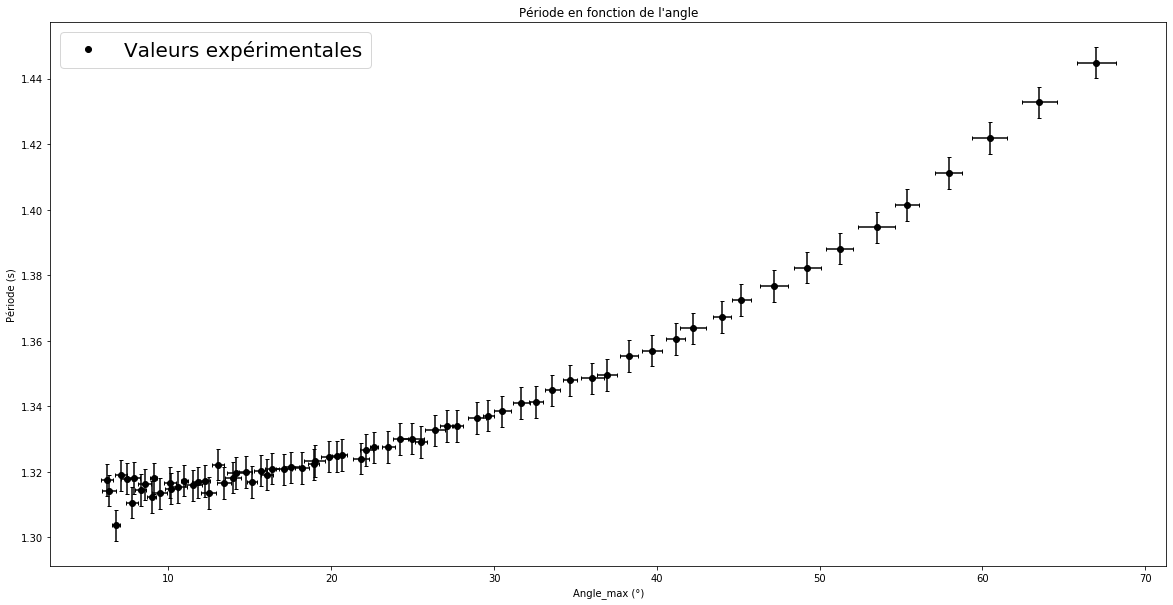

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
import numpy as np
from scipy.optimize import curve_fit
from math import *

#Fonction utile pour l'ajustement

def bordaFunc(x,periode0,b,c):
    xtemp = np.array(x)
    y = periode0*(1+(xtemp*pi/180.)**2/b+(xtemp*pi/180.)**4/c)
    return y

# Il faut enregistrer le fichier latis pro avec comme séparateur décimal un point et comme séparateur entre valeurs un point virgule
# dans le répertoire courant du Jupyter.
# Attention de bien enregistrer une fois le pendule lancé. Choisir un temps d'échantillonage de 50 ms et une durée de + de 600 secondes
# sur LatisPro avec un pendule qui bat la seconde.

nomreadfile = "bordadonnees.txt" #fichier à lire
nomwritefile = "resultsBorda.txt" #fichier à écrire
nomwritefile1 = "resultsBorda1.txt" #fichier à écrire
boolfit = False
# On commence par lire le document pour extraire les informations d'angle et de temps

f = open(nomreadfile, "r")
lines = f.readlines()
isfirstline = 0;

temps = []
angle = []


for line in lines:
    if isfirstline==0:
        isfirstline=1
    else : 
        temps.append(float(line.split(';')[0]))
        angle.append(float(line.split(';')[1]))
 
longueurtemps = len(temps)
tempsechant = temps[1]-temps[0]


##################################### Détermination des annulations #########################################

#On recherche maintenant les temps pour lesquels le pendule passe par 0

tempspass0 = []
indicepass0 = []

#On commence par une recherche bête, puis on retirera les erreurs (les valeurs trop proches)
tempsinter1 =-1
tempsinter2 = -1
for i in range(len(temps)-1):
    #On cherche les changements de signe
    if angle[i]*angle[i+1]<=0:
        #On fait une interpolation avec les 2 points qui changent de signe
        tempsinter2 = (angle[i+1]*temps[i]-angle[i]*temps[i+1])/(angle[i+1]-angle[i])
        #On retire les points trop proches (erreurs liées à l'incertitude sur U de la plaquette SYSAM)
        if tempsinter1==-1 or tempsinter2-tempsinter1>3*tempsechant:
            tempspass0.append(tempsinter2)
            indicepass0.append(i)
            tempsinter1 = tempsinter2

#Affichage graphique des points trouvés
tdeb1 = 100
tfin1 = 170

f = plt.figure(1)
plt.plot(temps,angle, 'ro-')
plt.plot(tempspass0,[0]*len(tempspass0), 'bo')
plt.axis([tdeb1, tfin1, min(angle),max(angle)])
plt.title("Extraction des temps de passage par zéros")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (°)")

##################################### Détermination des maximums #########################################

#On va ensuite cherche les maximums entre chaque annulation
nbremax = len(indicepass0)-1
valeurmax = []
tempsmax = []

for i in range(nbremax):
    listetemp = []
    for x in angle[indicepass0[i]+1:indicepass0[i+1]]:
        listetemp.append(abs(x))
    tempsmax.append(temps[listetemp.index(max(listetemp))+indicepass0[i]+1])
    valeurmax.append(max(listetemp))

#Affichage graphique des points trouvés
tdeb2 = 20
tfin2 = 22
    
f = plt.figure(2)
plt.plot(temps,angle, 'ro-')
plt.plot(tempsmax,valeurmax, 'bo')
plt.axis([tdeb2, tfin2, min(angle),max(angle)])
plt.title("Extraction des maximum sur chaque section")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (°)")

################################## 1ere idee Clustering sur les amplitudes ###################################

#On va maintenant faire du clustering (en supposant que l'amplitude ne fait que décroître)

varangle = 3 #pas pour le clustering
anglefinal = []
uanglefinal = []
periodefinal = []
uperiodefinal = []

inddeb = 0
i=1
while i<nbremax:
    valeurtemp =  valeurmax[inddeb]
    while i<nbremax and valeurmax[i]+varangle>valeurtemp:
        i+=1
    indfin = i
    anglefinal.append(np.mean(valeurmax[inddeb:indfin+1]))
    uanglefinal.append(np.std(valeurmax[inddeb:indfin+1]))
    periodefinal.append(2*(tempspass0[indfin]-tempspass0[inddeb])/(indfin-inddeb))
    uperiodefinal.append(2*(tempsechant/2)/(indfin-inddeb))
    inddeb = i+1
    i+=1
if boolfit:
    par_fit,cov=curve_fit(bordaFunc,anglefinal,periodefinal,p0 = [1,16,200],sigma=uperiodefinal,absolute_sigma=True)
    T0est = par_fit[0]
    best = par_fit[1]
    cest = par_fit[2]
    chisquarered = sum((periodefinal-bordaFunc(anglefinal,T0est,best,cest))**2/np.array(uperiodefinal)**2)/len(periodefinal)
    print("Le Xcarréréduit vaut {}".format(chisquarered))

#Affichage et sauvegarde dans un fichier annexe

f = plt.figure(3)
plt.plot(anglefinal,periodefinal, 'ko',label ='Valeurs expérimentales')
plt.xlabel("Angle_max (°)")
plt.ylabel("Période (s)")
plt.errorbar(anglefinal,periodefinal, yerr = uperiodefinal, xerr = uanglefinal,fmt = 'none', capsize = 2, ecolor = 'black', zorder = 1)
anglemod = np.linspace(0,90,1000)
plt.title("Angle max en ° en fonction de la période")
if boolfit:
    plt.plot(anglemod,bordaFunc(anglemod,T0est,best,cest),'k--',label="Modèle")
plt.title("Période en fonction de l'angle")
plt.legend(fontsize="20")


f = open(nomwritefile, "a")
for i in range(len(periodefinal)):
    f.write("{} {} {} {}\n".format(periodefinal[i],uperiodefinal[i],anglefinal[i],uanglefinal[i]))
    
    
################### 2 eme idée : On parcout un nombre de période suffisant et on moyenne

nombredemiperiode = 10
anglefinal1=[]
uanglefinal1 = []
periodefinal1=[]
uperiodefinal1= []
nombredeseg = (len(tempspass0)-1)//nombredemiperiode

for i in range(nombredeseg):
    anglefinal1.append(np.mean(valeurmax[i*nombredemiperiode:(i+1)*nombredemiperiode]))
    uanglefinal1.append(np.std(valeurmax[i*nombredemiperiode:(i+1)*nombredemiperiode]))   
    periodefinal1.append(2*(tempspass0[(i+1)*nombredemiperiode]-tempspass0[i*nombredemiperiode])/nombredemiperiode)
    uperiodefinal1.append(2*(tempsechant/2)/(nombredemiperiode))
    
f = plt.figure(4)
plt.plot(anglefinal1,periodefinal1, 'ko',label ='Valeurs expérimentales')
plt.xlabel("Angle_max (°)")
plt.ylabel("Période (s)")
plt.errorbar(anglefinal1,periodefinal1, yerr = uperiodefinal1, xerr = uanglefinal1,fmt = 'none', capsize = 2, ecolor = 'black', zorder = 1)
plt.title("Angle max en ° en fonction de la période")
if boolfit:
    anglemod = np.linspace(0,90,1000)
    plt.plot(anglemod,bordaFunc(anglemod,T0est,best,cest),'k--',label="Modèle")
plt.title("Période en fonction de l'angle")
plt.legend(fontsize="20")

f = open(nomwritefile1, "a")
for i in range(len(periodefinal1)):
    f.write("{} {} {} {}\n".format(periodefinal1[i],uperiodefinal1[i],anglefinal1[i],uanglefinal1[i]))
    

In [22]:
(i+1)*nombredemiperiode+1-(i*nombredemiperiode)


11